In [1]:
using Revise
using LinearAlgebra
using CartesianGrids
using ViscousFlow
using Test
using Plots
using ProgressMeter

┌ Info: Precompiling CartesianGrids [3e975e5d-2cf8-4263-9573-8460aaf534d9]
└ @ Base loading.jl:1342
┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compi

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [7]:
abstract type AbstractLevelSetFunction end


"""
    CircleLevelSetFunction(x0, y0, r; isclosed)
Level set function for a disk
"""
struct CircleLevelSetFunction <: AbstractLevelSetFunction
    r::Float64
    x0::Float64
    y0::Float64
    isclosed::Bool
    function CircleLevelSetFunction(r::Float64, x0::Float64, y0::Float64; isclosed::Bool = true)
        return new(r, x0, y0, isclosed)
    end
end

function (f::CircleLevelSetFunction)(x,y)
    if f.isclosed == true
        return sqrt((x-f.x0)^2 + (y-f.y0)^2)-f.r <= 0
    else
        return sqrt((x-f.x0)^2 + (y-f.y0)^2)-f.r < 0
    end
end

In [8]:
## Spatial patch field ##

"""
    SpatialPatch(r,x0,y0,A)
Set up a spatial field in the form of a region of constant amplitude `A` over the domain 𝓢. 
The domain 𝓢 is defined implicitly by the Boolean indicator function (i.e. level set function) χ:
χ(x) = true if x ∈ 𝓢 and χ(x) = false otherwise. 
"""
struct SpatialPatch{T} <: AbstractSpatialField where T <: AbstractLevelSetFunction
    # Level set function for the set 𝓢
    χ::T
    A::Float64
end

function (g::SpatialPatch{T})(x,y) where T <: AbstractLevelSetFunction
    if g.χ(x,y) == true
        return g.A
    else
        return 0.0
    end
end

(g::SpatialPatch)(x,y,t)  = g(x,y)

In [9]:
"""
    CircleSpatialPatch(r,x0,y0,A)
Set up a spatial field with constant amplitude `A` in the form of a disk 
centered at `x0, y0` and radius `r`. Note that a closed disk with zero radius is a point. 
"""
function CircleSpatialPatch(r, x0, y0, A; isclosed::Bool=true) 
    @assert r>= 0.0 "radius of the circle should be positive (>=0)"
    
    χcircle = CircleLevelSetFunction(r, x0, y0; isclosed = isclosed)
    return SpatialPatch{CircleLevelSetFunction}(χcircle, A)
end

function Base.show(io::IO, patch::SpatialPatch{T}) where T<:CircleLevelSetFunction
    if patch.χ.isclosed == true  
       println(io, "Closed circular patch of radius = $(patch.χ.r), centered at $(patch.χ.x0), $(patch.χ.y0) and amplitude $(patch.A).")
    else
        println(io, "Open circular patch of radius = $(patch.χ.r), centered at $(patch.χ.x0), $(patch.χ.y0) and amplitude $(patch.A).")
    end
end

In [10]:
@testset "Test CircleSpatialPatch" begin
    patch = CircleSpatialPatch(0.3, 0.0, -1.0, 0.5)
    @test patch(0.1, 0.9) == 0.0
    @test patch(0.1, -0.9) == patch.A
end

Test Summary:           | Pass  Total
Test CircleSpatialPatch |    2      2


Test.DefaultTestSet("Test CircleSpatialPatch", Any[], 2, false, false)

In [11]:
Re = 300
gridRe = 3

3

In [12]:
xlim = (-2.0,12.0)
ylim = (-2.0,2.0)
Δx, Δt = setstepsizes(Re, gridRe = gridRe)

(0.01, 0.005)

In [13]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt)

Unbounded Navier-Stokes system on a grid of size 1404 x 416 and 0 static immersed points
   Static freestream = (0.0, 0.0)


In [14]:
rpatch = 0.5
dpatch = 1.2
Γpatch = 6.0
Upatch = Γpatch/(2*π*dpatch)

xω, yω = coordinates(state(newstate(sys)), sys.grid)

patch1 = CircleSpatialPatch(rpatch, 0.0, dpatch/2.0, 0.0)
patch2 = CircleSpatialPatch(rpatch, 0.0, -dpatch/2.0, 0.0)

Npatch1 = 0
Npatch2 = 0
for xi in xω
    for yj in yω
        if patch1.χ(xi,yj) == true
            Npatch1 += 1
        elseif patch2.χ(xi,yj) == true
            Npatch2 += 1
        end
    end
end 

patch1 = SpatialPatch(patch1.χ, Γpatch/(Npatch1*Δx^2))
patch2 = SpatialPatch(patch2.χ, -Γpatch/(Npatch2*Δx^2))

patch =  patch1 + patch2

u1 = newstate(patch1, sys)
u2 = newstate(patch2, sys)

@show sum(state(u1)*Δx^2) -  Γpatch*Δx
@show sum(state(u2)*Δx^2) +  Γpatch*Δx;

sum(state(u1) * Δx ^ 2) - Γpatch * Δx = -7.605027718682322e-15
sum(state(u2) * Δx ^ 2) + Γpatch * Δx = 7.605027718682322e-15


In [15]:
@show Upatch

Upatch = 0.7957747154594768


0.7957747154594768

In [16]:
u0 = newstate(patch, sys)

(Dual nodes in a (nx = 1404, ny = 416) cell grid of type Float64 data
  Number of Dual nodes: (nx = 1404, ny = 416), Float64[])

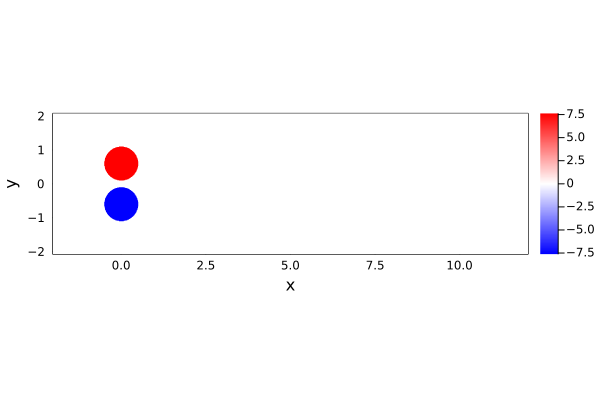

In [17]:
heatmap(xω, yω, vorticity(state(u0), sys, 0.0), color = cgrad([:blue; :white; :red]), ratio = 1.0, xlabel = "x", ylabel = "y",
        xlims = (-Inf, Inf), ylims = (-Inf, Inf), colorbar = true)

In [18]:
tspan = (0.0,12.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 1404, ny = 416) cell grid of type Float64 data
  Number of Dual nodes: (nx = 1404, ny = 416), Float64[])

In [28]:
Δs = 0.01
xsensors = collect(-1.5:Δs:11)
Ny = size(xsensors,1)
ysensors = zeros(Ny);

# grid points for primal nodes
xp, yp = coordinates(pressure(u0, sys, 0.0), sys.grid)

tlist = 0.0:Δt:12.0
press = zeros(Ny, length(tlist))
pressitp = interpolatable_field(xp, yp, pressure(u0, sys, 0.0))
press[:,1] .= deepcopy(pressitp.(xsensors, ysensors));

signpatch = 1.0


whist = typeof(state(u0))[]
push!(whist, deepcopy(state(u0)));

In [30]:
@showprogress for (i, ti) in enumerate(tlist[1:end-1])
    integrator = init(integrator.sol.u[end],(ti, ti+Δt),sys)
    step!(integrator, Δt)
    
    # Save state every 0.5 time units
    if  abs(round(Int64, integrator.t/0.5)-(integrator.t/0.5))<1000*eps()
        @show integrator.t
        push!(whist, deepcopy(state(integrator.sol[end])))
        save("state_vortex_patch_CFD_t_"*string(ceil(Int64, tspan[end]))*"_Re_"*string(ceil(Int64, Re))*
             "_gridRe_"*string(ceil(Int64, gridRe))*"_rpatch_"*string(ceil(Int64, 100*rpatch))*
             "_dpatch_"*string(ceil(Int64, 100*dpatch))*
             "_Gpatch_"*string(ceil(Int64, 100*Γpatch))*"_2.jld", "w", whist)
    end
    
    # Compute pressure
    pressitp = interpolatable_field(xp, yp, pressure(integrator.sol, sys, integrator.t))
    press[:,i+1] = deepcopy(pressitp.(xsensors, ysensors))

    save("pressure_vortex_patch_CFD_t_"*string(ceil(Int64, tspan[end]))*"_Re_"*string(ceil(Int64, Re))*
         "_gridRe_"*string(ceil(Int64, gridRe))*"_rpatch_"*string(ceil(Int64, 100*rpatch))*
         "_dpatch_"*string(ceil(Int64, 100*dpatch))*
         "_Gpatch_"*string(ceil(Int64, 100*Γpatch))*"_2.jld", "p", press)
end

Progress:   4%|█▊                                       |  ETA: 1:02:34

integrator.t = 0.5


Progress:   8%|███▍                                     |  ETA: 1:00:21

integrator.t = 1.0


Progress:  12%|█████▏                                   |  ETA: 0:56:43

integrator.t = 1.5


Progress:  17%|██████▉                                  |  ETA: 0:53:44

integrator.t = 2.0


Progress:  21%|████████▌                                |  ETA: 0:51:18

integrator.t = 2.5


Progress:  25%|██████████▎                              |  ETA: 0:48:32

integrator.t = 3.0


Progress:  29%|████████████                             |  ETA: 0:45:45

integrator.t = 3.5


Progress:  33%|█████████████▋                           |  ETA: 0:43:06

integrator.t = 4.0


Progress:  37%|███████████████▍                         |  ETA: 0:40:21

integrator.t = 4.5


Progress:  42%|█████████████████▏                       |  ETA: 0:37:45

integrator.t = 5.0


Progress:  46%|██████████████████▊                      |  ETA: 0:35:06

integrator.t = 5.5


Progress:  50%|████████████████████▌                    |  ETA: 0:32:22

integrator.t = 6.0


Progress:  54%|██████████████████████▎                  |  ETA: 0:29:37

integrator.t = 6.5


Progress:  58%|███████████████████████▉                 |  ETA: 0:27:04

integrator.t = 7.0


Progress:  62%|█████████████████████████▋               |  ETA: 0:24:26

integrator.t = 7.5


Progress:  67%|███████████████████████████▍             |  ETA: 0:21:43

integrator.t = 8.0


Progress:  71%|█████████████████████████████            |  ETA: 0:19:01

integrator.t = 8.5


Progress:  75%|██████████████████████████████▊          |  ETA: 0:16:17

integrator.t = 9.0


Progress:  79%|████████████████████████████████▌        |  ETA: 0:13:35

integrator.t = 9.5


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:10:53

integrator.t = 10.0


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:08:09

integrator.t = 10.5


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:05:26

integrator.t = 11.0


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:02:44

integrator.t = 11.5


Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:02

integrator.t = 12.0


Progress: 100%|█████████████████████████████████████████| Time: 1:04:53


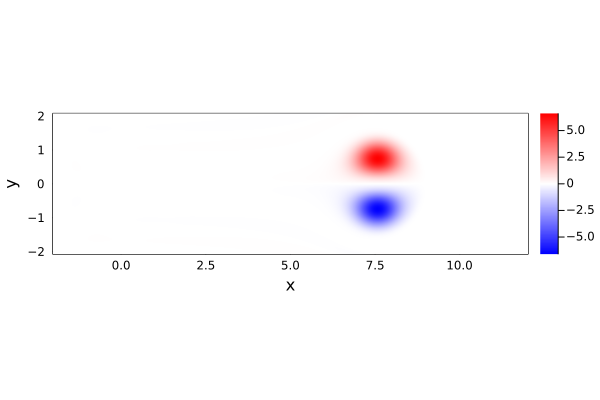

In [16]:
heatmap(xω, yω, vorticity(state(integrator.sol), sys, 12.0), color= cgrad([:blue; :white; :red]), ratio = 1.0, xlabel = "x", ylabel = "y",
        xlims = (-Inf, Inf), ylims = (-Inf, Inf), colorbar = true)
# contour!(xω, yω, ViscousFlow.streamfunction(state(sol), sys, 4.0), color= :grey, colorbar = false)